In [ ]:
import pickle
import re
import numpy as np
import tensorflow as tf
from tensorflow.train import Checkpoint, CheckpointManager
from keras import Input, Model
from keras.layers import TextVectorization, Embedding, Flatten, Dense, Dropout, LSTM, GRU, add, StringLookup
from keras.models import Sequential
from keras.utils.all_utils import plot_model, to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from tensorflow import GradientTape
from PIL import Image
import os

FEATURES_PATH = '/content/drive/MyDrive/Data/Image-Captioning-Data/features.pkl'
CAPTIONS_PATH = '/content/drive/MyDrive/Data/Image-Captioning-Data/Flicker-Text/Flickr8k.token.txt'
CHECKPOINT_PATH = '/content/drive/MyDrive/Data/Image-Captioning-Data/checkpoint/train'

VOCAB_SIZE = 8800
EMBED_SIZE = 256
MAX_CAP_LEN = 40
BATCH_SIZE = 64

## Encoder 
- Feature extracted from VGG16 

In [ ]:
base_model = VGG16(include_top=True)
base_model.trainable = False

# Taking till Flaten layer
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

# model.summary()
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# img_features.shape

In [ ]:
features = pickle.load(open(FEATURES_PATH, 'rb'))

## Preprocessing Caption

In [ ]:
# Creating a dictionary of 'captions' with 'image_id' as a key
def load_caption_data(filepath):
    caption_mapping = {}

    # Reading caption file
    with open(filepath, 'r') as file:
        captions = file.read()

    #looping through every line
    for line in captions.split('\n'):
        #spliting b/w captions and image name
        split_line = line.split()
        if len(split_line) <= 3:
            print(split_line)
            continue
        # fetching image name without format
        img_name = split_line[0].split('.')[0]
        # fetching caption
        curr_caption = ' '.join(split_line[1:])

        # if img_name key is not in dict then declared that key
        if img_name not in caption_mapping:
            caption_mapping[img_name] = []
        # appending every caption for an img_name
        caption_mapping[img_name].append(curr_caption)
    
    return caption_mapping

In [ ]:
caption_mapping = load_caption_data(CAPTIONS_PATH)

['2165461920_1a4144eb2b.jpg#0', 'dogs', 'racing']
['2428275562_4bde2bc5ea.jpg#0', 'A']
['244760301_5809214866.jpg#3', 'People', 'walking']
['256085101_2c2617c5d0.jpg#3', 'Dog', 'yawns']
['2714703706_d21c5cb8df.jpg#0', 'dogs', 'playing']
['2755314937_1e974bf2b5.jpg#3', 'broken', 'image']
['2862481071_86c65d46fa.jpg#4', 'Trucks', 'racing']
['2929669711_b2d5a640f0.jpg#4', 'man', 'surfing']
['3108732084_565b423162.jpg#2', 'a', 'snowboarder']
['3125309108_1011486589.jpg#2', 'rugby', 'match']
['3154693053_cfcd05c226.jpg#0', 'A', 'basketball']
['3189251454_03b76c2e92.jpg#3', 'dog', 'barking']
['3237760601_5334f3f3b5.jpg#1', 'A', 'skier']
['3360823754_90967276ec.jpg#3', 'Man', 'skateboarding']
['3640443200_b8066f37f6.jpg#0', 'a']
['3664928753_7b0437fedf.jpg#3', 'Javelin', 'competition']
['3694071771_ce760db4c7.jpg#0', 'a', 'cyclist']
[]


In [ ]:
# Number of images
len(caption_mapping)

8092

In [ ]:
# checking captions of a perticular 'image_id'
caption_mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
#  Caption Preprocessing :-
# - converting to lower case
# - removing numbers, special charectors
# - removing last and first whitespaces
# - concatenating '<start>' and '<end>' strings

def preprocessing_captions(caption_mapping):
    # iterating over caption mapping
    for img_name, captions in caption_mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # changing upper-case char to lower-case
            caption = caption.lower()

            # using regex removing special characters and numbers
            caption = re.sub('[^a-z ]', '', caption)
            
            # To remove front and back white spaces
            caption = caption.strip()

            #adding <start> and <end> string this will help in lstm
            captions[i] = '<start> ' + caption + ' <end>'

In [ ]:
preprocessing_captions(caption_mapping)

In [ ]:
# checking changes in a particular image
caption_mapping['1000268201_693b08cb0e']

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']

## Train Test Split

In [ ]:
# copying image_id in a list and spliting image_id into train list and test list
all_image_keys = [key for key in caption_mapping.keys()]
# I have done 0.8 train and 0.2 test split
till = int(len(caption_mapping) * 0.8)
train = all_image_keys[:till]
test = all_image_keys[till:]

In [ ]:
print('Train: ', len(train))
print('Test: ', len(test))

Train:  6473
Test:  1619


In [ ]:
features['1000268201_693b08cb0e']

array([[2.507647, 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

In [ ]:
# storing all captions in a dictionary
all_captions = []

for key, captions in caption_mapping.items():
    for caption in captions:
        all_captions.append(caption)
all_captions[:4]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>']

In [ ]:
len(all_captions)

40443

In [ ]:
#           X                      y

#   '<start>'                     'a'
#   '<start>', 'a'                'child'
#   '<start>', 'a', 'child'       'in' 


# Using 'TextVectorization' for representing words in integer
vectorization = TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode = "int",
    output_sequence_length=40,
    standardize=None
)

vectorization.adapt(all_captions)

In [ ]:
# example
vectorization('boxing')

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([1127,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

In [ ]:
cap_dataset = tf.data.Dataset.from_tensor_slices(all_captions)
for x in cap_dataset.as_numpy_iterator():
    print(x)
    break

b'<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>'


In [ ]:
vectorization

In [ ]:
# storing all vocabulary in a numpy array
input_vocab = np.array(vectorization.get_vocabulary())
print(input_vocab[:9])
print('Vocab Size: ', len(input_vocab))

# converting integer to word
print('Caption in integer: ', vectorization(caption_mapping['1000268201_693b08cb0e'][0]))
tokens = input_vocab[vectorization(caption_mapping['1000268201_693b08cb0e'][0])]
print('Caption in words: ', ' '.join(tokens))

['' '[UNK]' 'a' '<start>' '<end>' 'in' 'the' 'on' 'is']
Vocab Size:  8781
Caption in integer:  tf.Tensor(
[   3    2   43    5    2   91  171    8  120   54    2  397   13  395
    5   29 7731  695    4    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
Caption in words:  <start> a child in a pink dress is climbing up a set of stairs in an entry way <end>                     


In [ ]:
#tensorflow.python.framework.ops.EagerTensor
# tf.squeeze(vectorization(caption_mapping['1000268201_693b08cb0e'][0]))

# checking how it will look like after converting into array

In [ ]:
# # created an object for converting index into corresponding word with the help of 'StringLookup' layer by keras
# def idx_word_and_word_idx(vocabulary):
#     index_to_word = StringLookup(vocabulary = vectorization.get_vocabulary(),
#                                  oov_token='UNK',
#                                  invert=True)
#     word_to_index = StringLookup(vocabulary=vectorization.get_vocabulary())    
#     return index_to_word, word_to_index

In [ ]:
# index_to_word, word_to_index = idx_word_and_word_idx(vectorization)

# print(word_to_index('<start>'))
# print(index_to_word(3))
# print(vectorization('<start>'))

## Dataset created with batch size of 64

In [ ]:

def creating_dataset(all_keys):
    img_vec, cap_vec = [], []
    for img_key in tqdm(all_keys):
        try:
            # image feature is extracted 
            img_vec.extend([features[img_key][0]] * len(caption_mapping[img_key]))
            # append label and captions
            cap_vec.extend(vectorization(caption_mapping[img_key]))
            # print(img_vec)
            # print(cap_vec)
        except:
            print('\nThis image have no Features: ', img_key)
    return img_vec, cap_vec

In [ ]:
img_train_feat, img_train_cap = creating_dataset(train)
img_test_feat, img_test_cap = creating_dataset(test)

 21%|██        | 1353/6473 [00:06<01:03, 80.08it/s]


This image have no Features:  2258277193_586949ec62


100%|██████████| 1619/1619 [00:06<00:00, 237.81it/s]


In [ ]:
# length of feat and caption of one image
print(len(img_train_feat[0]))
print(len(img_train_cap[0]))

4096
40


## Model

In [ ]:
# from keras.layers.merge import Add
# # encoder
# enc_input1 = Input(shape=(None, 4096))
# enc_dropout1 = Dropout(0.4)(enc_input1)
# enc_dense = Dense(512, activation='relu')(enc_dropout1)

# # decoder
# # input shape = (BATCH_SIZE, 40)
# dec_input1 = Input(shape=(None, ))
# dec_embed1 = Embedding(VOCAB_SIZE, EMBED_SIZE, mask_zero=True)(dec_input1)
# dec_lstm1 = LSTM(512)(dec_embed1)
# dec_dense1 = Dense(512)(dec_lstm1)

# add_layer = add([dec_dense1, enc_dense])
# dec_dense2 = Dense(VOCAB_SIZE, activation='softmax')(add_layer)

# model = Model(inputs = [enc_input1, dec_input1], outputs=dec_dense2)

In [ ]:
# model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# def train_model(model):
#     epochs = 1
#     for epoch in range(epochs):
#             x = creating_dataset(BATCH_SIZE, features, train, caption_mapping, vectorization, MAX_CAP_LEN)
#             # print(x)
#             # print(len(x[0]))
#             # print(np.array(x[0][0]).shape)
#             # print(np.array(x[0][1]).shape)
#             # print(np.array(x[1]).shape)
#             model.fit(x, epochs=1)
#         # print(img_feat)
#         # print(curr_caption)
#         # print(curr_label)

In [ ]:
# train_model(model)

In [ ]:
# model.predict([np.array([temp_img_train[1]]), np.array([temp_cap_train[1]])]).argmax()

## Practicing LSTM

In [ ]:
# x = [[x + 1, x + 2, x + 3] for x in range(1000)]
# y = [[x] for x in range(4, 1004)]


# x = np.array(x)
# y = np.array(y)
# x = x.reshape([-1, 3, 1])
# # print(x)
# # print(y)

# input = Input(shape=(3, 1))
# lstm = LSTM(120)(input)
# dropout = Dropout(0.4)(lstm)
# dense = Dense(1)(dropout)
# model = Model(inputs = input, outputs=dense)

# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.losses.MeanSquaredError()])
# model.fit(x, y, epochs = 1)

In [ ]:
# model.predict(np.array([[8, 9, 10]]))

# Tensorflow Guide

In [ ]:
MAX_CAP_LEN = 40
FEAT_SHAPE = 4096
BATCH_SIZE = 64
EMB_DIM = 256
UNITS = 512
NUM_STEPS = len(train)//BATCH_SIZE

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_train_feat, img_train_cap))

# Shuffle and batch
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class Decoder(Model):
    def __init__(self, units, vocab_size, emb_dim):
        super().__init__()
        self.units = units

        self.dropout0 = Dropout(0.5)
        self.dense0 = Dense(self.units, activation='relu')

        self.embed = Embedding(vocab_size, emb_dim)
        self.gru = GRU(self.units)
        self.dense1 = Dense(self.units, activation='relu')
        self.dense2 = Dense(vocab_size, activation='softmax')

    def call(self, img_cap, feat):
        # shape of img_cap (BatchSize, 1)
        # shape of feat (BatchSize, 4096)

        # 1. Image features from VGG16 
        feat = self.dropout0(feat)
        feat = self.dense0(feat)

        # 2. Image Caption 
        img_cap = self.embed(img_cap)
        img_cap = self.gru(img_cap)
        
        # adding output of image feature and next generated word for caption
        img_cap = add([feat, img_cap])
        
        # passing it to dense layer
        img_cap = self.dense1(img_cap)
        img_cap = self.dense2(img_cap)

        return img_cap

In [ ]:
decoder = Decoder(UNITS, VOCAB_SIZE, EMB_DIM)

In [ ]:
# checking with one image
img_cap = decoder(np.array(img_train_cap[0][0]).reshape(1, -1), tf.expand_dims(img_train_feat[0], 0))

In [ ]:
img_cap

<tf.Tensor: shape=(1, 8800), dtype=float32, numpy=
array([[7.8501565e-05, 9.8254335e-05, 1.1885639e-04, ..., 6.9650829e-05,
        1.0282979e-04, 1.3537370e-04]], dtype=float32)>

In [ ]:
input_vocab[np.argmax(img_cap)]

'cadet'

In [ ]:
# loss and optimizer
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.optimizers.Adam()

def cal_loss(target, pred):
    curr_loss = loss(target, pred)
    return curr_loss

# Checkpoint

In [ ]:
# checkpoint is used to store all weights after every training
ckpt = Checkpoint(optimizer = optimizer, model = decoder)
ckpt_manager = CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=5)

# Training

In [ ]:
from tensorflow.python.ops.variables import trainable_variables
def train_per_batch(img_feats, img_caps):
    batch_loss = 0

    # GradientTape was used to update weights  
    with GradientTape() as tape:
        for i in range(MAX_CAP_LEN - 1):
            # expanding dims of img_caps so shape will become (BatchSize, 1, 1)
            curr_words = tf.expand_dims(img_caps[:, i], 1)
            predictions = decoder(curr_words, img_feats)

            # calculating current batch loss for one word and adding to var 'batch_loss'
            true_label = to_categorical(img_caps[:, i+1], num_classes = VOCAB_SIZE)
            batch_loss += tf.math.reduce_mean(cal_loss(true_label, predictions))
    # To find trainable variables of this algorithm
    # print(decoder.trainable_variables) 

    # fetching all trainable variable
    trainable_variables = decoder.trainable_variables
    # differentiating all trainable variables
    gradient = tape.gradient(batch_loss, trainable_variables)
    # applying 'Adam' optimizer 
    optimizer.apply_gradients(zip(gradient, trainable_variables))

    return batch_loss

In [ ]:
START_EPOCH = 0
if ckpt_manager.latest_checkpoint:
    START_EPOCH = ckpt_manager.latest_checkpoint.split('-')[-1]
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:


epochs = 7

for curr_epoch in range(int(START_EPOCH), epochs):
    for (batch, (img_feats, img_caps)) in enumerate(dataset):
        batch_loss = train_per_batch(img_feats, img_caps)

        if batch % 100 == 0:
            print('Epoch:', curr_epoch + 1, ',Batch:', batch, ',Loss:', np.array(batch_loss)/int(img_caps.shape[0]))
    ckpt_manager.save()

Epoch: 5 ,Batch: 0 ,Loss: 0.5499570965766907
Epoch: 5 ,Batch: 100 ,Loss: 0.5848283171653748
Epoch: 5 ,Batch: 200 ,Loss: 0.6025406718254089
Epoch: 5 ,Batch: 300 ,Loss: 0.6109745502471924
Epoch: 5 ,Batch: 400 ,Loss: 0.5668447017669678
Epoch: 5 ,Batch: 500 ,Loss: 0.5470075011253357


In [ ]:
print(decoder.losses)

In [ ]:
# import pickle

# train_var = decoder.trainable_variables
# pickle.dump(train_var, 'wb')

In [ ]:
test[:4]

['3601569729_bf4bf82768',
 '3601803640_5f3cb05acf',
 '3601843201_4809e66909',
 '3601978895_9fec23ce0c']

# Evaluating

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_test_feat, img_test_cap))

dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from IPython.display import display

def open_img(img_name):
    path = os.path.join('/content/drive/MyDrive/Data/Image-Captioning-Data/Flicker-Data/Flicker8k_Dataset', img_name + '.jpg')
    img = Image.open(path)
    display(img)

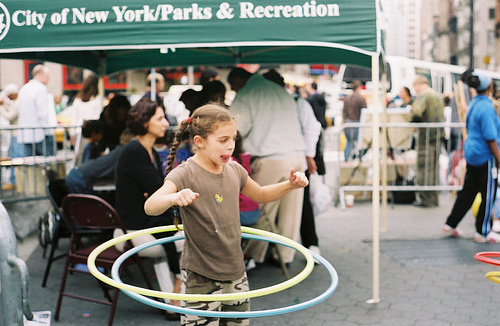

True Caption:  <start> a girl is hula hooping on a sidewalk in new york <end>
Predicted Caption:  <start> a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a 


In [ ]:
def evaluate(img_feat, img_cap):
    curr_word = tf.expand_dims([vectorization('<start>')[0]], 1)
    img_feat = tf.expand_dims(img_feat, 0)
    predicted = '<start> '
    # print(img_feat)
    # print(curr_word)
    for i in range(MAX_CAP_LEN):
        # decoder will return array of vocabulary size(vocab_size) 
        predict = decoder(curr_word, img_feat)
        # np.argmax(predict) will return index of max value, 
        # putting max value in input_vocab we get corresponding word
        word_predict = input_vocab[np.argmax(predict)]
        predicted += word_predict + ' '
        # print(predicted)
        curr_word = tf.expand_dims([np.argmax(predict)], 1)

        # if 'predict' word contain <end> then we will return predicted till now
        if word_predict == '<end>':
            print('True Caption: ', img_cap)
            return predicted
    print('True Caption: ', img_cap)
    return predicted
idx = 998
open_img(test[idx])
print('Predicted Caption: ', evaluate(features[test[idx]], caption_mapping[test[idx]][0]))

In [ ]:
test[idx]

'3601803640_5f3cb05acf'